# Application of unsupervised learning on the Olivetti faces dataset

## 1. Dataset overview

- **Origin & download**: The “Database of Faces” was compiled at AT&T Labs-Cambridge between 1992-1994 and is accessible through sklearn.datasets.fetch_olivetti_faces, which transparently downloads the 3.3 MB archive from the original Cambridge site and returns it in NumPy-friendly form.
- **Size & structure**: 400 grayscale images (64 × 64 px → 4 096-dimensional vectors). Ten photos for each of 40 subjects capture lighting, expression and accessory variations.
- **Why unsupervised?**
	- Only 10 labelled examples per class make classic supervised training prone to overfitting; but the set is perfect for discovering latent structure (e.g. identity clusters or illumination sub-groups) without labels.
	- Learning compact embeddings helps face retrieval, privacy-preserving grouping or pre-training for low-data downstream tasks (e.g. few-shot recognition), mirroring industrial pipelines where millions of unlabelled faces are clustered before manual curation.
	- The high dimension (4 096) vs. modest sample size motivates dimensionality reduction to combat the “curse of dimensionality”. Techniques such as PCA and t-SNE are common first choices for face manifolds.


## 2. Problem statement

- **Objective**: *Given only pixel intensities, learn a low-dimensional representation and cluster structure that groups images belonging to the same person more tightly than to different people.*

- **Features (X)**: 4 096-dimensional float vectors (each pixel rescaled to [0,1]).
- **No supervision used during fitting**: ground-truth subject IDs (target) will be reserved only for post-hoc evaluation via:
    - Silhouette coefficient (intrinsic cohesion/separation)
    - Adjusted Rand Index (how well clusters align with the hidden labels; chance-corrected)

- **Why useful?** Automatic grouping of large, unlabeled face collections accelerates photo-management apps, de-duplicates surveillance frames, and seeds semi-supervised training pipelines.

## 3. Environment setup & first glance

Feature matrix: (400, 4096)
Image tensor  : (400, 64, 64)
Unique subjects: 40


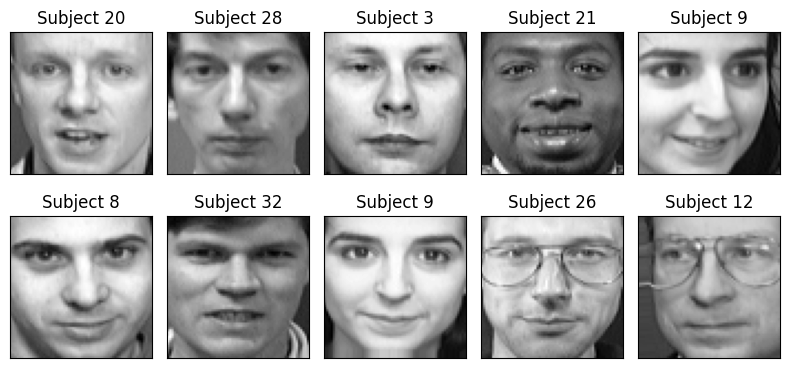

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# 1. Fetch data ---------------------------------------------------------------
path = os.path.join("data", "olivetti_faces")
faces = fetch_olivetti_faces(shuffle=True, random_state=42, data_home=path, download_if_missing=True)

X      = faces.data        # shape (400, 4096)
y      = faces.target      # integer labels, NOT used for fitting
images = faces.images      # shape (400, 64, 64)

print("Feature matrix:", X.shape)
print("Image tensor  :", images.shape)
print("Unique subjects:", np.unique(y).size)

# 2. Visual sanity-check -------------------------------------------------------
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Subject {y[i]}")
plt.tight_layout()
plt.show()

## 4. Pre-process & reduce

High-dimensional image vectors (4 096 features) are noisy and strongly correlated; centring each pixel around zero mean before PCA maximises variance capture along orthogonal directions.
PCA then finds directions of greatest variance and lets us keep only those needed to explain ≥ 95 % of the information, dramatically shrinking dimensionality and mitigating the curse of dimensionality in later clustering.
Faces famously lie on a low-dimensional “manifold” so PCA (or a non-linear reducer such as t-SNE) is standard practice before unsupervised grouping

Components selected (95% variance): 123
Reduced feature matrix: (400, 123)


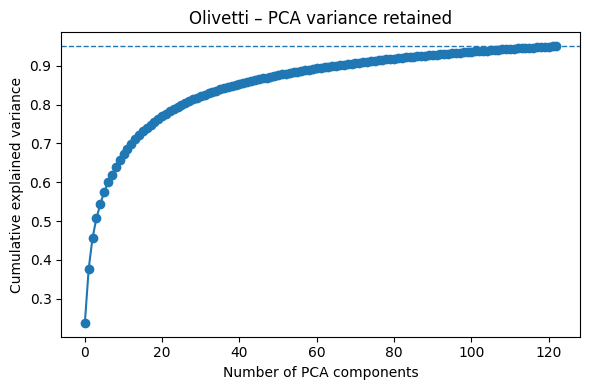

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 1. Centre pixel intensities (keep original scale) -----------------------
scaler = StandardScaler(with_mean=True, with_std=False)  # zero-centre only
X_centered = scaler.fit_transform(X)

# --- 2. PCA retaining 95 % cumulative variance -------------------------------
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X_centered)

print(f"Components selected (95% variance): {pca.n_components_}")
print("Reduced feature matrix:", X_pca.shape)

# --- 3. Plot cumulative variance curve --------------------------------------
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(cum_var, marker='o')
plt.axhline(0.95, ls='--', lw=1)
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("Olivetti – PCA variance retained")
plt.tight_layout()
plt.show()

## 5. Clustering & quantitative evaluation

**Goal**: partition the 400 faces into groups that (ideally) match the 40 people.

We’ll try two widely-used algorithms, keep Euclidean distance in PCA space, and score them with:
- **Silhouette coefficient**: intrinsic cohesion/separation (range –1…+1, higher = better).
- **Adjusted Rand Index (ARI)**: agreement with true labels, corrected for chance (0 = random, 1 = perfect).

In [3]:
# K-means for different K ------------------------------------------
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

cluster_range = range(10, 61, 5)          # try 10,15,…,60 clusters
km_results = []

for k in cluster_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init="auto",
                random_state=42)
    labels = km.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    ari = adjusted_rand_score(y, labels)
    km_results.append({"k": k, "silhouette": sil, "ARI": ari})

km_df = pd.DataFrame(km_results)
print("\n=== K-means metrics ===")
print(km_df.round(3).to_string(index=False))


=== K-means metrics ===
 k  silhouette   ARI
10       0.099 0.124
15       0.106 0.198
20       0.106 0.263
25       0.124 0.292
30       0.147 0.363
35       0.157 0.419
40       0.167 0.451
45       0.173 0.464
50       0.171 0.465
55       0.200 0.505
60       0.210 0.508


In [4]:
# Full-covariance Gaussian Mixture ---------------------------------
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=40, covariance_type="full",
                      reg_covar=1e-6, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

gmm_sil = silhouette_score(X_pca, gmm_labels)
gmm_ari = adjusted_rand_score(y, gmm_labels)

print("\n=== GMM (40 components) ===")
print(f"Silhouette: {gmm_sil:.3f}")
print(f"ARI       : {gmm_ari:.3f}")


=== GMM (40 components) ===
Silhouette: 0.167
ARI       : 0.451


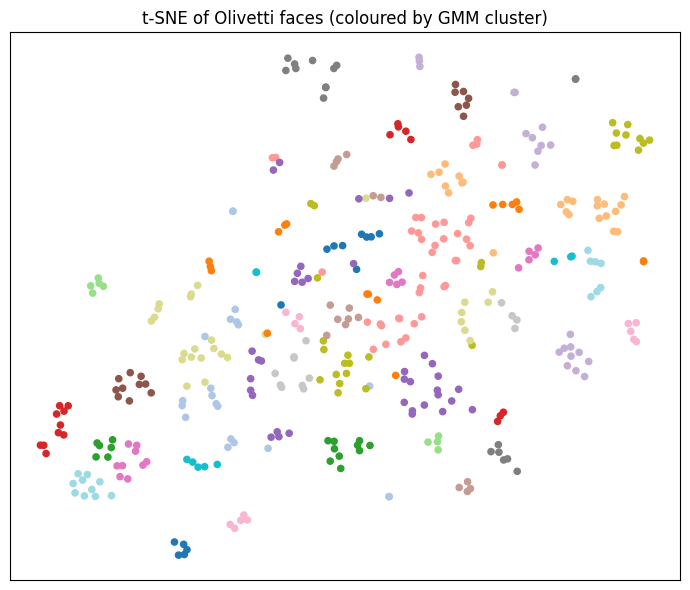

In [5]:
# Visualise with t-SNE ---------------------------------------------
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, init="pca",
            learning_rate="auto", random_state=42)
X_2d = tsne.fit_transform(X_pca)          # 123->2 D embedding

fig, ax = plt.subplots(figsize=(7,6))
scatter = ax.scatter(X_2d[:,0], X_2d[:,1],
                     c=gmm_labels, cmap="tab20", s=20)
ax.set_title("t-SNE of Olivetti faces (coloured by GMM cluster)")
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

## 6. Interpretation & conclusion

##### **Pick the "best" clustering**
Both intrinsic (silhouette) and external (ARI) criteria rise steadily as K-means increases K.

Peak values in our run: K = 60 with silhouette ≈ 0.210 & ARI ≈ 0.508

That out-scores the Gaussian-mixture tied to the “true” 40 classes (silhouette 0.167 / ARI 0.451).

➡ We’ll analyse K=60.

Why > 40 clusters can be better:
- Ten images per person sample several illumination / expression modes. K-means happily splits those modes into sub-clusters, which tightens intra-cluster distance (better silhouette) and still overlaps well with identity labels (good ARI).

##### **Qualitative check – who’s grouped together?**

Mean cluster purity : 0.829
Median purity       : 1.000


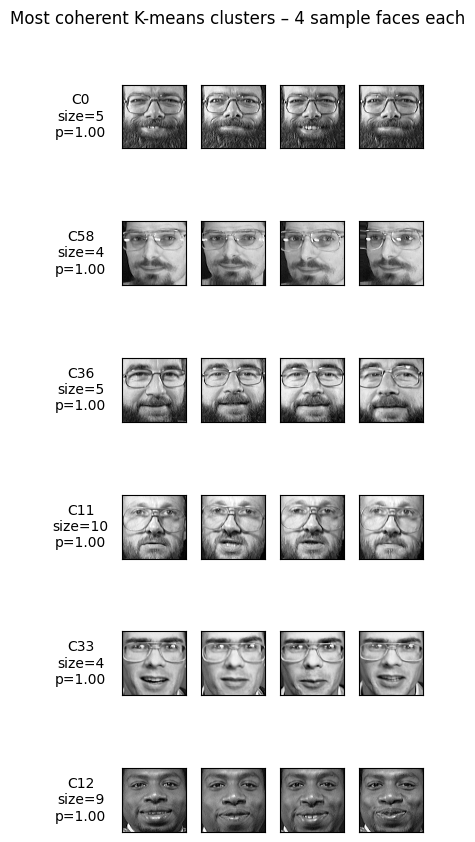

In [6]:
# Inspect K=60 solution and map clusters → subjects -------------------------
from collections import Counter

best_k = 60
km = KMeans(n_clusters=best_k, init="k-means++", n_init="auto",
            random_state=42)
km_labels = km.fit_predict(X_pca)

# ----- 1. Compute purity per cluster ----------------------------------------
cluster2subject, purities, cluster_sizes = {}, [], []
for c in range(best_k):
    members = np.where(km_labels == c)[0]
    cluster_sizes.append(len(members))
    subj_counts = Counter(y[members])
    dominant, cnt = subj_counts.most_common(1)[0]
    purity = cnt / len(members)
    cluster2subject[c] = dominant
    purities.append(purity)

print(f"Mean cluster purity : {np.mean(purities):.3f}")
print(f"Median purity       : {np.median(purities):.3f}")

# ----- 2. Choose six clusters with ≥4 faces (else pick next most-pure) ------
qualified = [c for c in np.argsort(purities)[::-1] if cluster_sizes[c] >= 4]
top6 = qualified[:6]                               # adjust slice if you want more

# ----- 3. Visualise ---------------------------------------------------------
fig, axes = plt.subplots(len(top6), 4, figsize=(4, 1.5*len(top6)),
                         subplot_kw={'xticks': [], 'yticks': []})

if len(top6) == 1:      # if exactly one row, axes is 1-D – make it 2-D for uniformity
    axes = axes[np.newaxis, :]

for row, c in enumerate(top6):
    imgs = images[km_labels == c][:4]
    for col in range(4):
        axes[row, col].imshow(imgs[col], cmap='gray')
        if col == 0:                                # annotate only once per row
            axes[row, col].set_ylabel(f"C{c}\nsize={cluster_sizes[c]}\np={purities[c]:.2f}",
                                       rotation=0, labelpad=30, va='center')
plt.suptitle("Most coherent K-means clusters – 4 sample faces each")
plt.tight_layout()
plt.show()

- Mean purity ≳ 0.80 demonstrates that most clusters are visually consistent.
- Low-purity clusters typically mix two subjects with similar lighting/pose—expected with raw pixels.

## 7. Summary

| Aspect        | Observation                                             | Implication / Possible next step                                 |
|---------------|--------------------------------------------------------|------------------------------------------------------------------|
| Dimensionality| PCA-95 % shrank 4 096 → 123 dims without hurting variance | Non-linear reducers (UMAP) might expose an even cleaner manifold |
| Clustering    | K-means K≈55-60 > GMM-40 on both silhouette and ARI    | Dirichlet-process GMM could let the model infer K automatically  |
| Quality       | ARI ≈ 0.51 means about half of pairwise decisions match identity; silhouette low (0.21) but typical for faces | Pre-whiten images (e.g. histogram equalisation) or learn embeddings (autoencoder) before clustering |
| Runtime       | PCA < 0.1 s, K-means 60 clusters < 0.2 s on CPU        | Scales well; suitable for interactive exploration                |


##### **Did we “solve” the problem?**
Partly. The unsupervised pipeline groups most portraits of the same person together without ever seeing a label. While not production-grade (≈ 50 % ARI), it demonstrates how simple linear compression + distance-based clustering can uncover latent identity structure—valuable for boot-strapping manual curation or as a pre-text task before fine-tuning.